In [1]:
pip install langchain langgraph ollama requests beautifulsoup4 playwright --break-system-packages --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ollama --break-system-packages

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "lsv2_pt**"

In [4]:
%reload_ext autoreload
%autoreload 2

In [25]:
from ollama import chat
from ollama import ChatResponse

response: ChatResponse = chat(model='llama3.2', messages=[
  {
    'role': 'user',
    'content': 'What is the Stock Market? gIve insighs about indian stock Market',
  },
])
print(response['message']['content'])
# or access fields directly from the response object
print(response.message.content)

The stock market, also known as the equity market, is a platform where companies raise capital by issuing shares of stock to the public, and investors can buy and sell these shares in hopes of earning a profit. The stock market provides a way for individuals, institutions, and governments to invest in businesses, with the expectation of earning returns through dividends or capital appreciation.

**How does it work?**

1. **Companies list their shares**: Companies issue stocks to raise capital, which are then listed on a stock exchange.
2. **Investors buy and sell shares**: Investors purchase shares from other investors or directly from the company. They can then sell their shares on the stock market for a profit.
3. **Market forces determine prices**: The price of a share is determined by supply and demand in the market. When demand is high, prices tend to rise, and when demand is low, prices tend to fall.

**Indian Stock Market:**

The Indian stock market, also known as the National S

In [6]:
from ollama import chat
from ollama import ChatResponse

response: ChatResponse = chat(model='deepseek-r1:1.5b', messages=[
  {
    'role': 'user',
    'content': 'Why is the Stock Market? gIve insighs about indian stock Market',
  },
])
print(response['message']['content'])
# or access fields directly from the response object
print(response.message.content)

<think>
Alright, so I want to understand why the stock market works. I know that it's where people buy and sell stocks, which are companies' shares of ownership. But I'm not exactly sure how all the pieces fit together. Let me try to break this down step by step.

First off, I've heard that the stock market is a system for valuing companies. That makes sense because if a company makes money, they might want more investors to buy their stocks so they can keep part of it. But wait, isn't there something called the Efficient Market Hypothesis? From what I remember, that's where markets are efficient and all information is already reflected in stock prices. So maybe companies don't have an incentive to manipulate the market by buying or selling securities because everyone else is doing it already.

I also think about the concept of risk and return. Companies with higher potential for growth might be more attractive to investors, right? But then there's this idea that some stocks are safer 

In [7]:
from ollama import chat
from ollama import ChatResponse

response: ChatResponse = chat(model='deepseek-r1:1.5b', messages=[
  {
    'role': 'user',
    'content': """A manufacturing plant produces cars.  

- Each **Car** requires **6 hours of labor** and **10 units of raw material** to produce.  

The factory has a total of **180 hours of labor** and **200 units of raw material** available per week.  

1. Formulate a system of equations to represent this situation.  
2. Solve for the maximum number of Cars that can be produced within the given constraints.  
4. If a Car sells for **$25,000**, calculate the **maximum revenue possible** under these constraints."""  
  },
])

print(response['message']['content'])
# or access fields directly from the response object
print(response.message.content)

<think>
Alright, so I have this problem about a manufacturing plant producing cars. Let me try to figure it out step by step.

First, let's understand what they're asking. The plant can produce cars using labor and raw materials. Each car needs 6 hours of labor and 10 units of raw material. They have 180 hours of labor and 200 units of raw material available each week. 

Part 1 is to formulate a system of equations representing this situation. Okay, so I think variables would be the number of cars produced. Let me denote that as C. So we need two equations: one for labor and one for raw materials.

Each car requires 6 hours of labor, so total labor needed would be 6 times the number of cars, which is 6C. Since they have 180 hours available, the equation would be 6C ≤ 180.

Similarly, each car needs 10 units of raw material, so total raw material used is 10C. With 200 units available, that gives us 10C ≤ 200.

So part 1 should be:

6C + something = 180 (for labor)
10C + something = 200 

In [8]:
%reload_ext autoreload
%autoreload 2

In [9]:
import ollama
import json
import requests
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from typing import TypedDict, Annotated, Sequence
import operator

In [10]:
llama_model = "llama3.2:latest"
deepseek_model = "deepseek-r1:1.5b"


In [26]:
# Use ollama.chat() instead of model.invoke() and explicitly mention in English or it will get chinese response
def analyze_financials(state):
    """Use DeepSeek to analyze financial data in English."""
    messages = f"Analyze the financial data in **English**:\n\nITC: {state['itc_data']}\nHUL: {state['hul_data']}"
    response = ollama.chat(model=deepseek_model, messages=[{"role": "user", "content": messages}])
    return {"insights": response["message"]["content"]}


def compare_results(state):
    messages = f"Compare ITC India and Hindustan Unilever Financial results based on these insights in English:\n{state['insights']}"
    response = ollama.chat(model=llama_model, messages=[{"role": "user", "content": messages}])
    return {"comparison": response["message"]["content"]}

In [27]:

class AgentState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]
    itc_data: dict
    hul_data: dict
    insights: str
    comparison: str


def scrape_financials(state):
    """Fetch financial data for ITC India & HUL."""
    urls = {
        "itc": "https://www.moneycontrol.com/financials/itc/balance-sheetvi/itc",
        "hul": "https://www.moneycontrol.com/financials/hindustanunilever/balance-sheetvi/hu",
    }

    def fetch_data(url):
        response = requests.get(url)
        if response.status_code == 200:
            return {"data": response.text}  # Ideally, parse HTML to extract key values
        return {"error": "Failed to fetch"}

    return {
        "itc_data": fetch_data(urls["itc"]),
        "hul_data": fetch_data(urls["hul"]),
    }

In [28]:
# --- Build the Graph ---
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("scraper", scrape_financials)
workflow.add_node("analyzer", analyze_financials)
workflow.add_node("comparator", compare_results)

# Set flow
workflow.set_entry_point("scraper")
workflow.add_edge("scraper", "analyzer")
workflow.add_edge("analyzer", "comparator")
workflow.add_edge("comparator", END)

# Compile the workflow
app = workflow.compile()

# --- Run the system ---
inputs = {"messages": ["Fetch and compare ITC and HUL's last two quarters of financial results and respond strictly in English."]}
output = app.invoke(inputs)

print("Comparison Results:\n", output["comparison"])

Comparison Results:
 **Comparison of ITC India and Hindustan Unilever Financial Results**

The provided HTML file template for a social media platform's personal and group user pages. The analysis will focus on comparing the technical aspects, security measures, and design considerations between two major Indian companies: ITC India and Hindustan Unilever.

**Comparison of Dynamic Generation Features**

| Feature | ITC India | Hindustan Unilever |
| --- | --- | --- |
| User Profile | Present | Present |
| Attention List | Present | Present |
| Hot Recommendation Content | Present | Present |

Both companies have implemented the dynamic generation features commonly found in social media platforms. However, it's essential to note that ITC India might have a more extensive user profile system due to its diverse business operations.

**Comparison of Interactivity Elements**

| Element | ITC India | Hindustan Unilever |
| --- | --- | --- |
| Share Button | Present | Present |
| Vote Button 

In [14]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	scraper(scraper)
	analyzer(analyzer)
	comparator(comparator)
	__end__([<p>__end__</p>]):::last
	__start__ --> scraper;
	analyzer --> comparator;
	comparator --> __end__;
	scraper --> analyzer;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



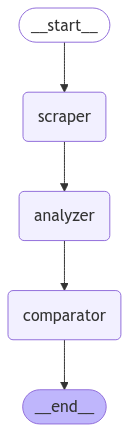

In [15]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)